In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,RocCurveDisplay,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings

#We import all the needed python libraries and open the needed file
df = pd.read_csv('calories_burned_fitgpt_gym.csv',index_col=0)

# I. Attribute type

## The columns in the given data are as follows:
Age, Gender, Weight (kg), Height (m), Max_BPM, Avg_BPM, Resting_BPM, Session_Duration (hours), Workout_Type, Fat_Percentage, Water_Intake (liters), Workout_Frequency (days/week), Experience_Level, BM and Calories_Burned.

Out of these all but two are numeric.
The other two are Workout_Type - Nominal and Gender - Binary (0 for male, 1 for female).

In [2]:
#We can print the data types and split them accordingly for later
dftypes = df.dtypes
nominals = np.array(dftypes[dftypes == object].keys())
numerics = np.array(dftypes[dftypes != object].keys())
print(f'Data types:\n{dftypes}\n')
print(f'Nominals: {nominals}\n')
print(f'Numerics: {numerics}')

Data types:
Gender                           object
Weight(kg)                      float64
Height(m)                       float64
Max_BPM                           int64
Avg_BPM                           int64
Resting_BPM                       int64
Session_Duration(hours)         float64
Calories_Burned                 float64
Workout_Type                     object
Fat_Percentage                  float64
Water_Intake(liters)            float64
Workout_Frequency(days/week)      int64
Experience_Level                  int64
BMI                             float64
dtype: object

Nominals: ['Gender' 'Workout_Type']

Numerics: ['Weight(kg)' 'Height(m)' 'Max_BPM' 'Avg_BPM' 'Resting_BPM'
 'Session_Duration(hours)' 'Calories_Burned' 'Fat_Percentage'
 'Water_Intake(liters)' 'Workout_Frequency(days/week)' 'Experience_Level'
 'BMI']


## II. Statistical characteristics for the features
Simple statistics for all the features.

In [3]:
print(f'Nominal features:\n{df.describe(include=[object])}')
print(f'Numeric features:\n {df.describe()}')

Nominal features:
       Gender Workout_Type
count     973          973
unique      2            4
top      Male     Strength
freq      511          258
Numeric features:
        Weight(kg)  Height(m)     Max_BPM     Avg_BPM  Resting_BPM  \
count  973.000000  973.00000  973.000000  973.000000   973.000000   
mean    73.854676    1.72258  179.883864  143.766701    62.223022   
std     21.207500    0.12772   11.525686   14.345101     7.327060   
min     40.000000    1.50000  160.000000  120.000000    50.000000   
25%     58.100000    1.62000  170.000000  131.000000    56.000000   
50%     70.000000    1.71000  180.000000  143.000000    62.000000   
75%     86.000000    1.80000  190.000000  156.000000    68.000000   
max    129.900000    2.00000  199.000000  169.000000    74.000000   

       Session_Duration(hours)  Calories_Burned  Fat_Percentage  \
count               973.000000       973.000000      973.000000   
mean                  1.256423       905.422405       24.976773   
std  

## III. Missing values

While with our given input file, there are not any missing values, we should still employ some methods of dealing with missing values.

In [4]:
#Showcasing that the file does not have any missing data
print('\nMissing data: ')
missing_data_means = df.isna().mean().sort_values(ascending=False)
missing_data_means


Missing data: 


Gender                          0.0
Weight(kg)                      0.0
Height(m)                       0.0
Max_BPM                         0.0
Avg_BPM                         0.0
Resting_BPM                     0.0
Session_Duration(hours)         0.0
Calories_Burned                 0.0
Workout_Type                    0.0
Fat_Percentage                  0.0
Water_Intake(liters)            0.0
Workout_Frequency(days/week)    0.0
Experience_Level                0.0
BMI                             0.0
dtype: float64

(For this example we will use a modified file with missing values.)

First we find the missing data in procentages and sort it.

In [5]:
df_missing = pd.read_csv('calories_burned_fitgpt_gym_missing.csv',index_col=0)
print('\nMissing data: ')
missing_data_means = df_missing.isna().mean().sort_values(ascending=False)
missing_data_means


Missing data: 


Gender                          0.572456
Height(m)                       0.116136
Session_Duration(hours)         0.038027
Weight(kg)                      0.000000
Avg_BPM                         0.000000
Max_BPM                         0.000000
Resting_BPM                     0.000000
Calories_Burned                 0.000000
Workout_Type                    0.000000
Fat_Percentage                  0.000000
Water_Intake(liters)            0.000000
Workout_Frequency(days/week)    0.000000
Experience_Level                0.000000
BMI                             0.000000
dtype: float64

We then select the ones that have 55% or more missing data for removal.
The ones with missing data less than 55% will be selected for data insertion.

In [6]:
columns_to_delete =  np.array(missing_data_means[missing_data_means >= 0.55].keys())
columns_to_add_to = np.array(missing_data_means[(missing_data_means > 0) & (missing_data_means<0.55)].keys())
print(f'{columns_to_delete= }')
print(f'{columns_to_add_to= }')


columns_to_delete= array(['Gender'], dtype=object)
columns_to_add_to= array(['Height(m)', 'Session_Duration(hours)'], dtype=object)


For imputing missing values, there are two possibilites:
1) Imputing the median if the missing value is numeric.
2) Imputing the most frequently occuring value if the value is nominal

In [7]:
#Imputing missing values
for column in columns_to_add_to:
    if column in nominals:
        imp_cat = SimpleImputer(strategy='most_frequent')
        df_missing[[column]] = imp_cat.fit_transform(df[[column]])
    elif column in numerics:
        imp_num = SimpleImputer(strategy='median')
        df_missing[[column]] = imp_num.fit_transform(df[[column]])

df[columns_to_add_to]



,Height(m),Session_Duration(hours)
Age,,
56,1.71,1.69
46,1.53,1.30
32,1.66,1.11
25,1.70,0.59
38,1.79,0.64
...,...,...
24,1.74,1.57
25,1.61,1.38
59,1.76,1.72


In [8]:
#Removing missing values
print(f'Columns before removal: {np.array(df_missing.columns)}')
print(f'Removing {columns_to_delete}')
df_missing = df_missing.drop(columns=columns_to_delete)
print(f'Columns after removal: {np.array(df_missing.columns)}')

Columns before removal: ['Gender' 'Weight(kg)' 'Height(m)' 'Max_BPM' 'Avg_BPM' 'Resting_BPM'
 'Session_Duration(hours)' 'Calories_Burned' 'Workout_Type'
 'Fat_Percentage' 'Water_Intake(liters)' 'Workout_Frequency(days/week)'
 'Experience_Level' 'BMI']
Removing ['Gender']
Columns after removal: ['Weight(kg)' 'Height(m)' 'Max_BPM' 'Avg_BPM' 'Resting_BPM'
 'Session_Duration(hours)' 'Calories_Burned' 'Workout_Type'
 'Fat_Percentage' 'Water_Intake(liters)' 'Workout_Frequency(days/week)'
 'Experience_Level' 'BMI']


In [9]:
missing_data_means = df.isna().mean().sort_values(ascending=False)
columns_to_delete =  np.array(missing_data_means[missing_data_means >= 0.55].keys())
columns_to_add_to = np.array(missing_data_means[(missing_data_means > 0) & (missing_data_means<0.55)].keys())

## Dummy columns
Before proceeding further, we will first deal with the dummy collumns (nominal values that could pose a challenge for our models).

These two are Gender and Workout_Type.
We will convert them to numeric values, so Gender will be go from "Male" and "Female" to 0 and 1.
Likewise, Workout Type's "Yoga","HIIT","Cardio" and "Strength" will become separate columns with values 0 and 1.

Before that, however, I would like to make a comparances between the calories, burned by Men and Women, and those, burned during a given Workout Type.

### Calories burned by Males vs Females

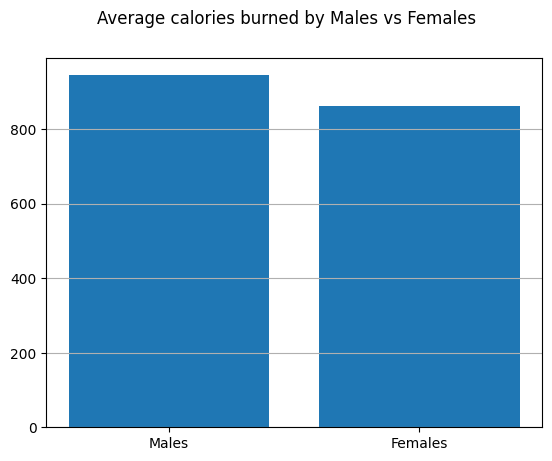

In [10]:
X_males = df[df['Gender'] == 'Male']
X_females = df[df['Gender'] == 'Female']
names = ['Males','Females']
data = [np.mean(X_males['Calories_Burned']),np.mean(X_females['Calories_Burned'])]
plt.bar(names,data)
plt.grid(axis='y')
plt.suptitle('Average calories burned by Males vs Females')
plt.show()

From this comparances we can see a clear bias towards Males as on average they burned more calories than Females do.
Thus it will be easier for a man to burn 800 calories than it will be for a woman.

We can do the same for the type of training, however since the average number of calories burned per training is more or less the same for all four, we can compare the average number of burned calories vs the overall amount of burned calories per training.

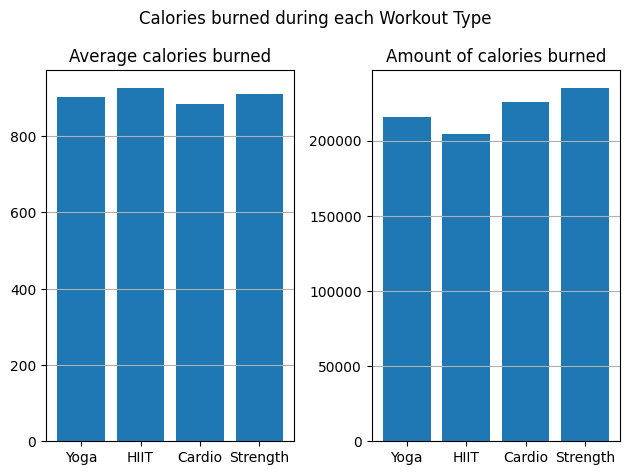

In [11]:
figure, axis = plt.subplots(1,2)
X_yoga = df[df['Workout_Type'] == 'Yoga']
X_hiit = df[df['Workout_Type'] == 'HIIT']
X_cardio = df[df['Workout_Type'] == 'Cardio']
X_strength = df[df['Workout_Type'] == 'Strength']
names = ['Yoga','HIIT','Cardio','Strength']
data_mean = [np.mean(X_yoga['Calories_Burned']),np.mean(X_hiit['Calories_Burned']),np.mean(X_cardio['Calories_Burned']),np.mean(X_strength['Calories_Burned'])]
data_sum = [np.sum(X_yoga['Calories_Burned']),np.sum(X_hiit['Calories_Burned']),np.sum(X_cardio['Calories_Burned']),np.sum(X_strength['Calories_Burned'])]
axis[0].bar(names,data_mean)
axis[0].grid(axis='y')
axis[0].set_title('Average calories burned')
axis[1].bar(names,data_sum)
axis[1].grid(axis='y')
axis[1].set_title('Amount of calories burned')
plt.suptitle('Calories burned during each Workout Type')
plt.tight_layout()
plt.show()


Unsurprisingly, the average number of calories burned per training does not differ that much per training type.

However it is interesting to see that the while the average number of burned calories for HIIT is the highest, the overall number for it is the lowest. This being said, we cannot eliminate any one type of training from the final model.

In [12]:
# We check whether the beforementioned columns have been deleted or not
X = df
if 'Gender' not in columns_to_delete:
    X = df.drop(columns=['Gender'])
    gender_dummies = pd.get_dummies(df['Gender'],dtype=int,drop_first=True)
    gender_dummies['Gender'] = gender_dummies.pop(df['Gender'].mode()[0])
    X = pd.concat([X,gender_dummies], axis=1)
if 'Workout_Type' not in columns_to_delete:
    workout_dummies = pd.get_dummies(df['Workout_Type'], dtype=int)
    X = X.drop(columns=['Workout_Type'])
    X = pd.concat([X,workout_dummies], axis=1)

columns = X.columns
np.array(columns)

array(['Weight(kg)', 'Height(m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration(hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake(liters)', 'Workout_Frequency(days/week)',
       'Experience_Level', 'BMI', 'Gender', 'Cardio', 'HIIT', 'Strength',
       'Yoga'], dtype=object)

## IV. Outliers
We can find outliers by using boxplot and analyzing the outlier points.

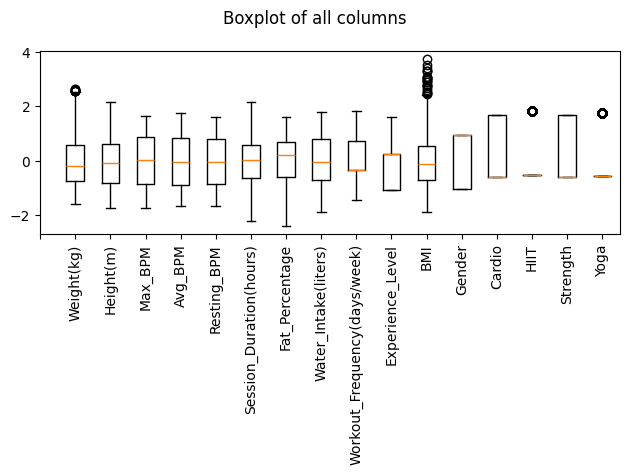

In [13]:
#Outliers
y = X['Calories_Burned']
X_outliers = X.drop(columns=['Calories_Burned'])

scaler = StandardScaler()
X_outliers_scaled = scaler.fit_transform(X_outliers)
plt.boxplot(X_outliers_scaled)
labels=['']+list(X_outliers.columns)
plt.xticks(ticks=range(len(X_outliers.columns)+1),labels=labels,rotation = 90)
plt.suptitle('Boxplot of all columns')
plt.tight_layout()
plt.show()


We can see that the only columns with outliers are Weight(kg), Session_Duration(hours), HIIT and Yoga.
We will now focus on each one individually.

As both HIIT and Yoga are either 0 or 1, outliers among them are hard to recognize so we will ignore them.

### Weight Outliers

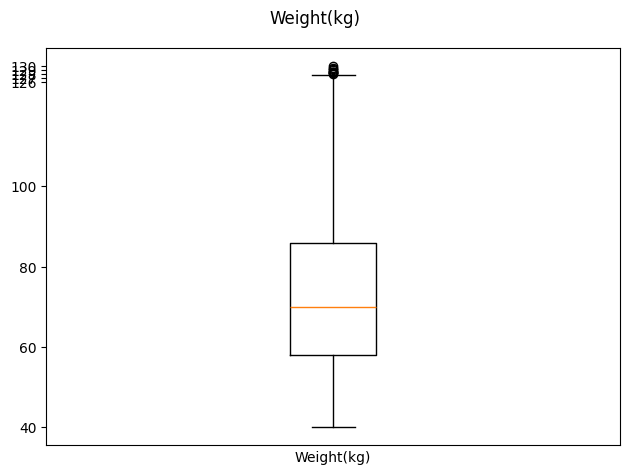

In [14]:
X_weight = X[['Weight(kg)','Calories_Burned']]
y = X_weight['Calories_Burned']
X_weight = X_weight.drop(columns=['Calories_Burned'])

plt.boxplot(X_weight)
plt.yticks(ticks=[40,60,80,100] + list(range(126,131)))
plt.xticks(ticks=[])
plt.xlabel('Weight(kg)')
plt.suptitle('Weight(kg)')
plt.tight_layout()
plt.show()


We can see that the outliers are values between 126 and 130.

### BMI Outliers

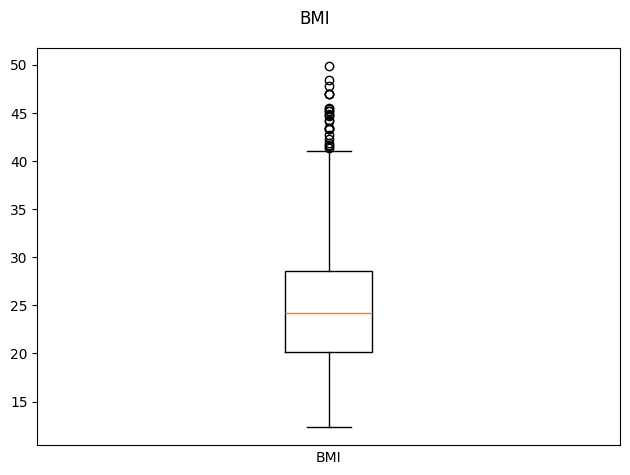

In [15]:
X_bmi = X[['BMI','Calories_Burned']]
y = X_bmi['Calories_Burned']
X_bmi = X_bmi.drop(columns=['Calories_Burned'])

plt.boxplot(X_bmi)
plt.xlabel('BMI')
plt.xticks(ticks=[])
plt.suptitle('BMI')
plt.tight_layout()
plt.show()

We can see that the BMI outliers and values between 41 and 50.

We will now remove the outliers.

In [16]:
X_weight_without_outliers = X['Weight(kg)'] <= 125
X_bmi_without_outliers = X['BMI'] <= 40
X = X[X_weight_without_outliers & X_bmi_without_outliers]
print(f'Dataframe without outliers:\n {X}')

Dataframe without outliers:
      Weight(kg)  Height(m)  Max_BPM  Avg_BPM  Resting_BPM  \
Age                                                         
56         88.3       1.71      180      157           60   
46         74.9       1.53      179      151           66   
32         68.1       1.66      167      122           54   
25         53.2       1.70      190      164           56   
38         46.1       1.79      188      158           68   
..          ...        ...      ...      ...          ...   
20         55.0       1.60      172      168           67   
24         87.1       1.74      187      158           67   
25         66.6       1.61      184      166           56   
59         60.4       1.76      194      120           53   
46         88.7       1.63      166      146           66   

     Session_Duration(hours)  Calories_Burned  Fat_Percentage  \
Age                                                             
56                      1.69           1313.0  

## V. Feature Importance and Selection

We will use Lasso regression to select the important features. 
Since there are four different types of training (HIIT, Strength, Cardio and Yoga) it would be best to check the feature imoprtance for all of them separately.


### Feature Importance for HIIT

d:\Machine Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+03, tolerance: 9.950e+02
  model = cd_fast.enet_coordinate_descent(


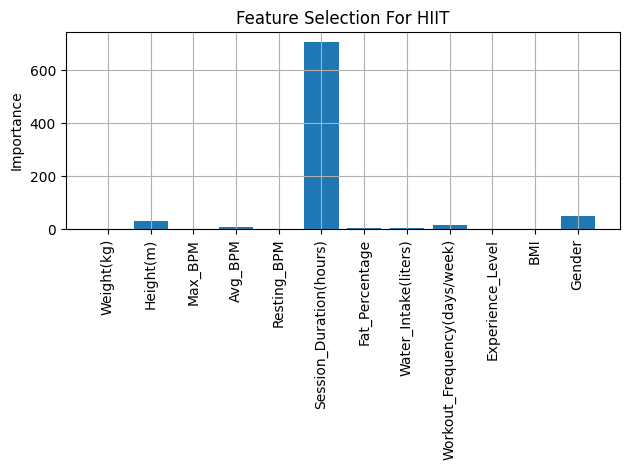

In [17]:
lasso = Lasso()

#Selecting only the rows with HIIT = 1
X_hiit = X[X['HIIT'] == 1]
X_hiit = X_hiit.drop(columns=['Cardio','Strength','Yoga','HIIT'])

y = X_hiit['Calories_Burned']
X_lasso = X_hiit.drop(columns=['Calories_Burned'])
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.33, random_state=42)
columns = X_lasso.columns
names=X_hiit.drop('Calories_Burned', axis=1).columns

las_reg = Lasso(alpha=0.00001)
las_reg.fit(X_train, y_train)

coef = np.abs(las_reg.coef_)

plt.bar(names, coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection For HIIT")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


d:\Machine Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.864e+04, tolerance: 1.119e+03
  model = cd_fast.enet_coordinate_descent(


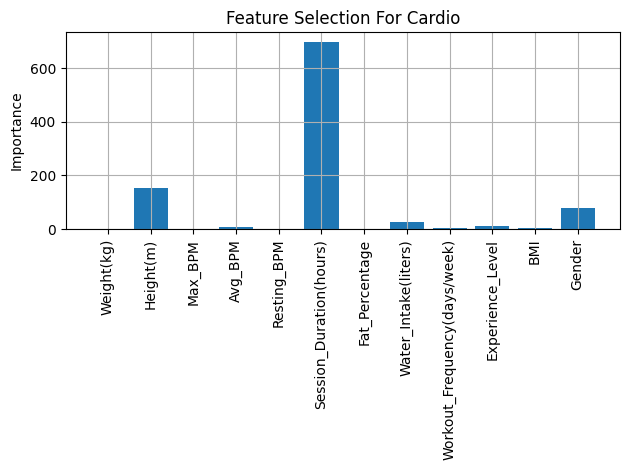

In [18]:
X_cardio = X[X['Cardio'] == 1]
X_cardio = X_cardio.drop(columns=['Cardio','Strength','Yoga','HIIT'])
y = X_cardio['Calories_Burned']
X_lasso = X_cardio.drop(columns=['Calories_Burned'])
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.33, random_state=42)
columns = X_lasso.columns
names=X_cardio.drop('Calories_Burned', axis=1).columns

las_reg = Lasso(alpha=0.00001)
las_reg.fit(X_train, y_train)

coef = np.abs(las_reg.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection For Cardio")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


d:\Machine Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.704e+04, tolerance: 1.246e+03
  model = cd_fast.enet_coordinate_descent(


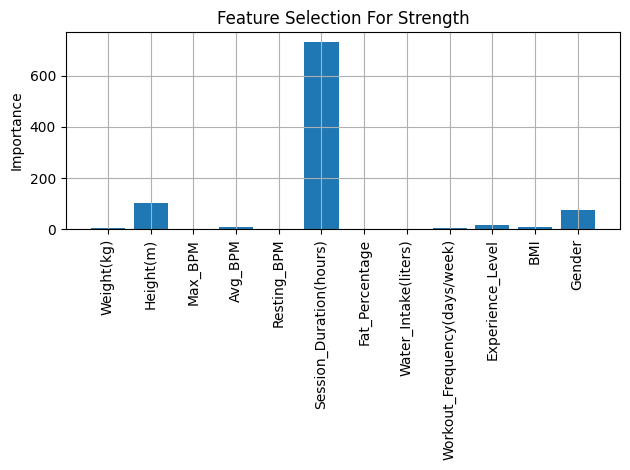

In [19]:
X_strength = X[X['Strength'] == 1]
X_strength = X_strength.drop(columns=['Cardio','Strength','Yoga','HIIT'])
y = X_strength['Calories_Burned']
X_lasso = X_strength.drop(columns=['Calories_Burned'])
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.33, random_state=42)
columns = X_lasso.columns
names=X_strength.drop('Calories_Burned', axis=1).columns

las_reg = Lasso(alpha=0.00001)
las_reg.fit(X_train, y_train)

coef = np.abs(las_reg.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection For Strength")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

d:\Machine Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.706e+04, tolerance: 1.249e+03
  model = cd_fast.enet_coordinate_descent(


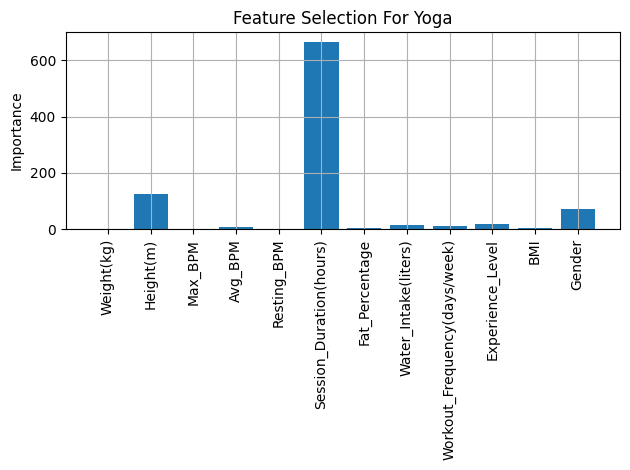

In [20]:
X_yoga = X[X['Yoga'] == 1]
X_yoga = X_yoga.drop(columns=['Cardio','Strength','Yoga','HIIT'])
y = X_yoga['Calories_Burned']
X_lasso = X_yoga.drop(columns=['Calories_Burned'])
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.33, random_state=42)
columns = X_lasso.columns
names=X_yoga.drop('Calories_Burned', axis=1).columns

las_reg = Lasso(alpha=0.00001)
las_reg.fit(X_train, y_train)

coef = np.abs(las_reg.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection For Yoga")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

As we can seen the bars of the features are mostly the same with some minor differences in some features.
We can surmise that those features whose coefficients are above 0 on the bars are the important ones and we can drop the rest.
To surmise, we can plot a final plot to unify our results.

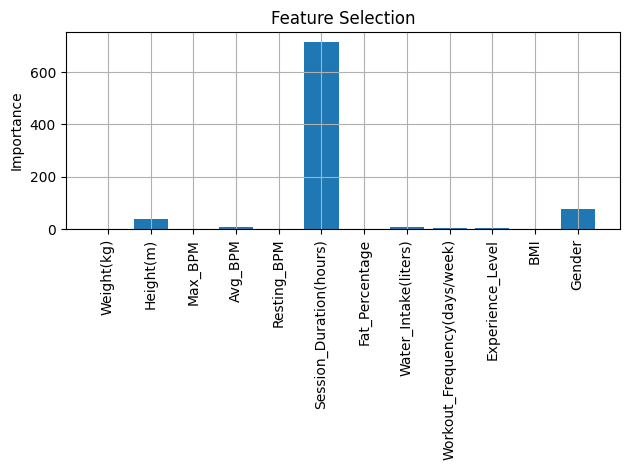

In [21]:
y = X['Calories_Burned']
X_lasso = X.drop(columns=['Calories_Burned','Cardio','Strength','Yoga','HIIT'])
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.33, random_state=42)
columns = X_lasso.columns
names=X_lasso.columns

las_reg = Lasso(alpha=0.00001)
las_reg.fit(X_train, y_train)

coef = np.abs(las_reg.coef_)

plt.bar(names, coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


We can surmise that the features we can for sure remove are Weight, Max_BPM and Resting_BPM, as they are 0 on all plots.

The Fat Percentage and BMI, while also close to 0, are relevant on some of the plots, so we will use them to train some of the models.

### VI. Regression Model

Before moving on to the final classification model, I would like to train a regression model which simply calculates the amount of burned calories for a given training. This will ofcourse be done with a linear regression model.

## Final Models

### Data Preparation
Before continuing we must prepare our data, more specifically the Calories Burned column.
As we want to train classification models, we cannot have our Calories Burned column me a numeric values.
Instead we will convert it to a binary value, 1 if the Burned Calories are more or equal to 800 and 0 if they are less than 800.
This will ensure that we have two categories.

In [22]:
y_more_than_800 = X[X['Calories_Burned'] >= 800]
y_less_than_800 = X[X['Calories_Burned'] < 800]
y_more_than_800.loc[:,'Calories_Burned'] = 1
y_less_than_800.loc[:,'Calories_Burned'] = 0

X_final = pd.concat([y_more_than_800,y_less_than_800])
X_final['Calories_Burned']

Age
56    1.0
46    1.0
56    1.0
36    1.0
40    1.0
     ... 
34    0.0
50    0.0
31    0.0
23    0.0
46    0.0
Name: Calories_Burned, Length: 927, dtype: float64



### K-Nearest Neighbours
We will first train a K-Nearest Neighbours (KNN) model.

The model will be trained with multiple dataframes and different number of neighbours.

The dataframe with which we will begin, will be the default dataframe with the columns for Weight, Max_BPM and Resting_BPM removed. We will than evaluate the model with different number of neighbours form 1 to 12.


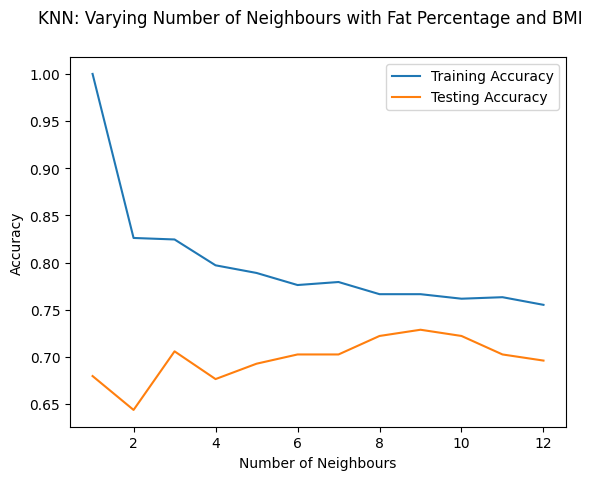

In [23]:
y = X_final['Calories_Burned']
X_knn = X_final.drop(columns=['Weight(kg)','Max_BPM','Resting_BPM','Calories_Burned'])
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.33, random_state=42)
neighbors=np.array(range(1,13))
train_accuracies1 = dict.fromkeys(neighbors)
test_accuracies1 = dict.fromkeys(neighbors)
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracies1[k] = round(knn.score(X_train,y_train),4)
    test_accuracies1[k] = round(knn.score(X_test,y_test),4)

plt.suptitle('KNN: Varying Number of Neighbours with Fat Percentage and BMI')
plt.plot(neighbors, train_accuracies1.values(), label='Training Accuracy')
plt.plot(neighbors, test_accuracies1.values(), label='Testing Accuracy')
plt.legend()
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.show() 

As we can see, the train accuracies do the best when we use a low number of neighbours.
The test accuracies are quite the opposite - as the number of neighbours increases, so does the accuracy.
Nevertheless, both of them plateau around 9 neighbours.

We will now conduct the same test, but without including Fat Percentage and BMI.

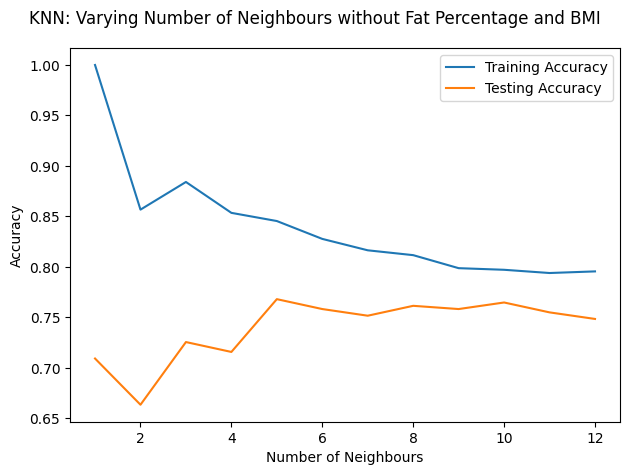

In [24]:
y = X_final['Calories_Burned']
X_knn = X_final.drop(columns=['Weight(kg)','Max_BPM','Resting_BPM','Calories_Burned','BMI','Fat_Percentage'])
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.33, random_state=42)
neighbors=np.array(range(1,13))
train_accuracies2 = dict.fromkeys(neighbors)
test_accuracies2 = dict.fromkeys(neighbors)
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracies2[k] = round(knn.score(X_train,y_train),4)
    test_accuracies2[k] = round(knn.score(X_test,y_test),4)

plt.suptitle('KNN: Varying Number of Neighbours without Fat Percentage and BMI')
plt.plot(neighbors, train_accuracies2.values(), label='Training Accuracy')
plt.plot(neighbors, test_accuracies2.values(), label='Testing Accuracy')
plt.legend()
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show() 

As we can see, without BMI and Fat Percentage the test accuracies do slightly better.

Plotting them on the same plot can show us this more accurately.

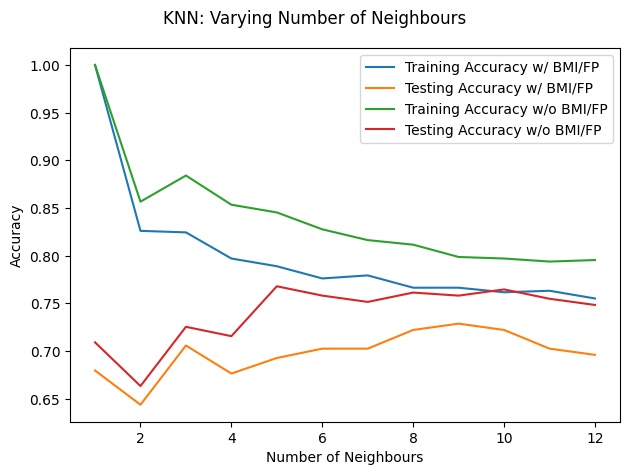

In [25]:
plt.suptitle('KNN: Varying Number of Neighbours')
plt.plot(neighbors, train_accuracies1.values(), label='Training Accuracy w/ BMI/FP')
plt.plot(neighbors, test_accuracies1.values(), label='Testing Accuracy w/ BMI/FP')
plt.plot(neighbors, train_accuracies2.values(), label='Training Accuracy w/o BMI/FP')
plt.plot(neighbors, test_accuracies2.values(), label='Testing Accuracy w/o BMI/FP')
plt.legend()
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show() 

To summarize, for higher number of neighbours, the model does way better if we do not include the BMI and Fat Percentage in the data frame.

As it is a bit difficult to tell by the graph, we can print the values of the test accuracies to determine, which number of neighbours is the best.


In [26]:
for key in sorted(test_accuracies2,key=test_accuracies2.get,reverse=True):
    print(f'Neigbhours: {key}, Test accuracy: {test_accuracies2[key]}')

Neigbhours: 5, Test accuracy: 0.768
Neigbhours: 10, Test accuracy: 0.7647
Neigbhours: 8, Test accuracy: 0.7614
Neigbhours: 6, Test accuracy: 0.7582
Neigbhours: 9, Test accuracy: 0.7582
Neigbhours: 11, Test accuracy: 0.7549
Neigbhours: 7, Test accuracy: 0.7516
Neigbhours: 12, Test accuracy: 0.7484
Neigbhours: 3, Test accuracy: 0.7255
Neigbhours: 4, Test accuracy: 0.7157
Neigbhours: 1, Test accuracy: 0.7092
Neigbhours: 2, Test accuracy: 0.6634


We can see that the best test accuracy for the KNN model is with 5 neigbhours and without including BMI and Fat Percentage in the data frame.

Finally, we will use a confusion matrix to evaluate the model.

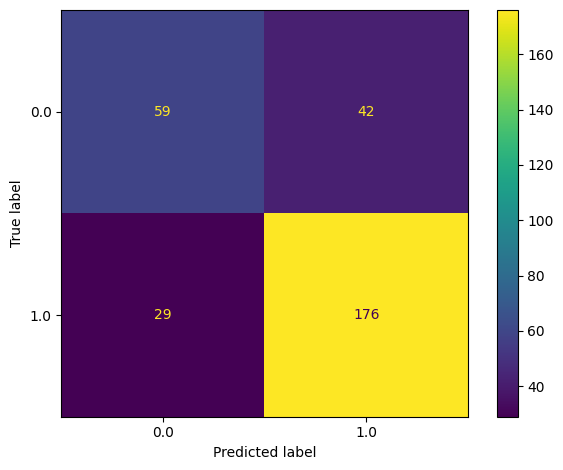

                       precision    recall  f1-score   support

   Under 800 calories       0.67      0.58      0.62       101
800 calories and over       0.81      0.86      0.83       205

             accuracy                           0.77       306
            macro avg       0.74      0.72      0.73       306
         weighted avg       0.76      0.77      0.76       306



In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
X_knn = X_final.drop(columns=['Weight(kg)','Max_BPM','Resting_BPM','Calories_Burned','BMI','Fat_Percentage'])
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.33, random_state=42)
knn.fit(X_train,y_train)
knn_predictions = knn.predict(X_test)
labels = ['Under 800 calories', '800 calories and over']
ConfusionMatrixDisplay.from_predictions(y_test, knn_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, knn_predictions, target_names=labels))


From the graphic we can see that most of our predictions from the model match the test values' classifications (both 0- Less than 800 burned calories- and 1- more than 800). Furthermore, from the accuracy, macro avg and weighted avg, we can say that the model's accuracy is quite good.


### Logistic Regression
#### Logistic Regression with BMI and Fat Percentage

As with the KNN model, we will compare the accuracy of the Logistic Regression with and without the BMI and Fat Percentage columns.

First off, without the BMI and Fat Percentage columns.

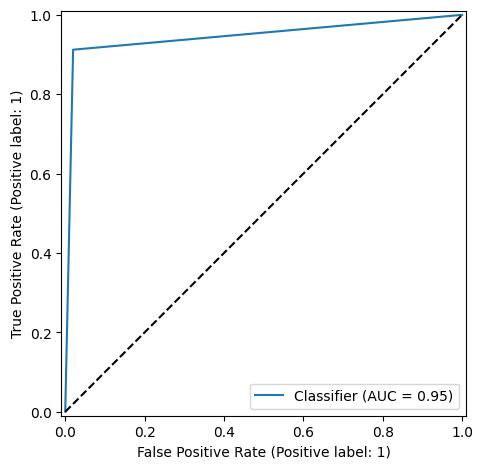

Model score: 0.934640522875817


In [28]:
X_lreg = X_final.drop(columns=['Weight(kg)','Max_BPM','Resting_BPM','Calories_Burned','BMI','Fat_Percentage'])
X_train, X_test, y_train, y_test = train_test_split(X_lreg, y, test_size=0.33, random_state=42)

#Scaling the data to make the calculations faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lreg = LogisticRegression(random_state=42)
lreg.fit(X_train_scaled,y_train)
lreg_predictions = lreg.predict(X_test_scaled)
RocCurveDisplay.from_predictions(y_test, lreg_predictions)
plt.plot([0, 1], [0, 1], 'k--')
plt.tight_layout()
plt.show()
score1 = lreg.score(X_test_scaled, y_test)
print(f'Model score: {score1}')


From the graphic we can gather that the model is almost perfect.

Both the Area Under the Curve is almost 1 and the True Positive Rate is 1.
Finally the Model Score is also almost perfect.

We can again use a Confusion Matrix to help visualize this.

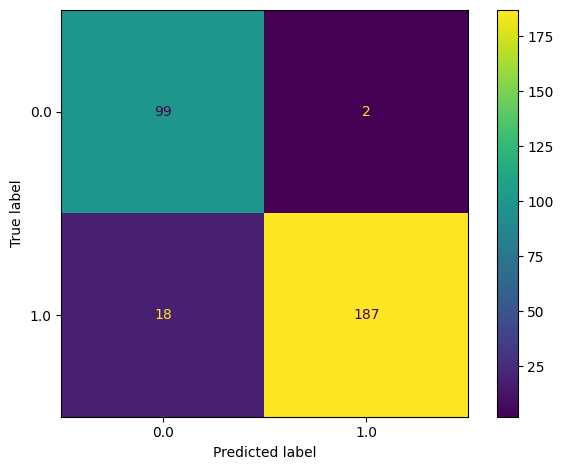

                       precision    recall  f1-score   support

   Under 800 calories       0.85      0.98      0.91       101
800 calories and over       0.99      0.91      0.95       205

             accuracy                           0.93       306
            macro avg       0.92      0.95      0.93       306
         weighted avg       0.94      0.93      0.94       306



In [29]:
labels = ['Under 800 calories', '800 calories and over']
ConfusionMatrixDisplay.from_predictions(y_test, lreg_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, lreg_predictions, target_names=labels))

From the Confusion Matrix, we can inquire that we have only a few false negatives and positives (only 20 across both false compared to over 200 in the true negatives and positives).

Furthermore, the precision for correctly classifying trainings that can burn over 800 calories is almost perfect (99%).

Now for the dataframe with BMI and Fat Percentage.

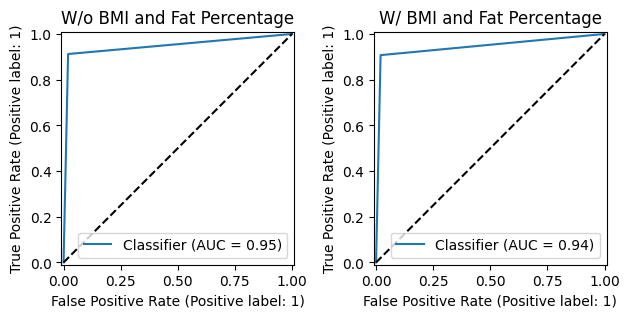

Model score (w/o vs w/):
 0.934640522875817 vs 0.9313725490196079


In [30]:
X_lreg = X_final.drop(columns=['Weight(kg)','Max_BPM','Resting_BPM','Calories_Burned'])
X_train, X_test, y_train, y_test = train_test_split(X_lreg, y, test_size=0.33, random_state=42)

#Scaling the data to make the calculations faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

figure, axis = plt.subplots(1,2)
lreg = LogisticRegression(random_state=42)
lreg.fit(X_train_scaled,y_train)
lreg_predictions2 = lreg.predict(X_test_scaled)
RocCurveDisplay.from_predictions(y_test, lreg_predictions,ax=axis[0])
axis[0].plot([0, 1], [0, 1], 'k--')
axis[0].set_title('W/o BMI and Fat Percentage')
RocCurveDisplay.from_predictions(y_test, lreg_predictions2,ax=axis[1])
axis[1].set_title('W/ BMI and Fat Percentage')

axis[1].plot([0, 1], [0, 1], 'k--')

plt.tight_layout()
plt.show()
print(f'Model score (w/o vs w/):\n {score1} vs {lreg.score(X_test_scaled, y_test)}')


As we can see, the model without BMI and Fat Percentage has a slight edge over the one with.

We will further explore this slight distinction with Confusion Matrixes.

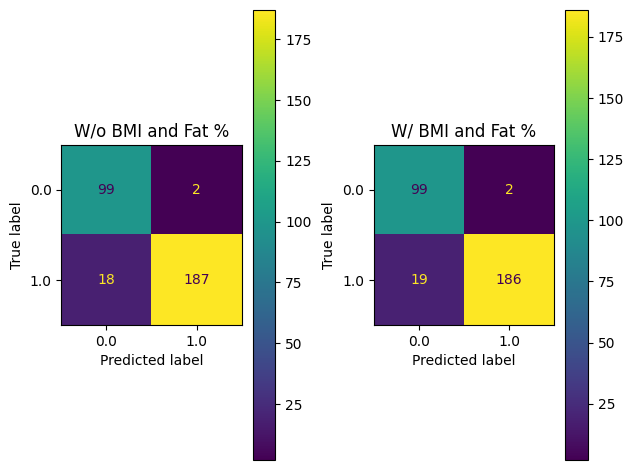

In [31]:

figure, axis = plt.subplots(1,2)
labels = ['Under 800 calories', '800 calories and over']
ConfusionMatrixDisplay.from_predictions(y_test, lreg_predictions,ax=axis[0])
axis[0].set_title('W/o BMI and Fat %')
ConfusionMatrixDisplay.from_predictions(y_test, lreg_predictions2,ax=axis[1])
axis[1].set_title('W/ BMI and Fat %')
plt.tight_layout()
plt.show()


Again from the Graphics we can spot a slight difference.
In fact, the difference is a single false positive more and thus a single true positive less.

In [32]:
print(f'Classification Report (w/o):\n {classification_report(y_test,lreg_predictions,target_names=labels)}')
print(f'Classification Report (w/):\n {classification_report(y_test,lreg_predictions2,target_names=labels)}')


Classification Report (w/o):
                        precision    recall  f1-score   support

   Under 800 calories       0.85      0.98      0.91       101
800 calories and over       0.99      0.91      0.95       205

             accuracy                           0.93       306
            macro avg       0.92      0.95      0.93       306
         weighted avg       0.94      0.93      0.94       306

Classification Report (w/):
                        precision    recall  f1-score   support

   Under 800 calories       0.84      0.98      0.90       101
800 calories and over       0.99      0.91      0.95       205

             accuracy                           0.93       306
            macro avg       0.91      0.94      0.93       306
         weighted avg       0.94      0.93      0.93       306



Likewise, the precision is only slightly off for the false positives (Under 800 calories in this case).

However small the difference though, we can inquire that the model using the dataframe without BMI and Fat Percentage has a slight edge over the one with.

As in both previous models, the dataframe without BMI and Fat Percentage were the more successful, going forward we won't be using these two columns.

### LinearSVC Model

We will now train a LinearSVC without any hyperparameter tuning.


Score: 0.9379084967320261


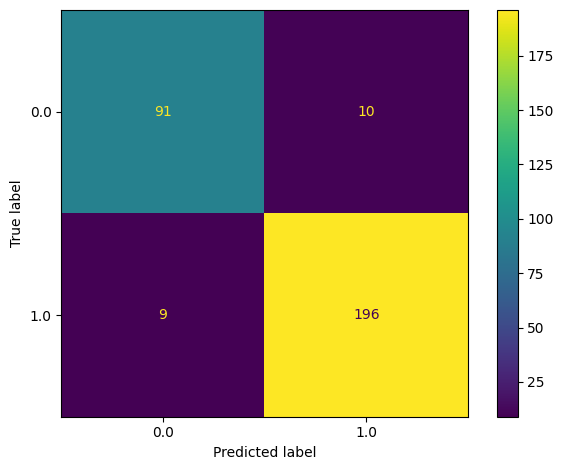

                       precision    recall  f1-score   support

   Under 800 calories       0.91      0.90      0.91       101
800 calories and over       0.95      0.96      0.95       205

             accuracy                           0.94       306
            macro avg       0.93      0.93      0.93       306
         weighted avg       0.94      0.94      0.94       306



In [33]:
X_final = X_final.drop(columns=['Weight(kg)','Max_BPM','Resting_BPM','Calories_Burned','BMI','Fat_Percentage'])
#As we will no longer use the BMI and Fat % columns we can update the X_final
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.33, random_state=42)
lsvc = svm.LinearSVC()
lsvc.fit(X_train,y_train)
print(f'Score: {lsvc.score(X_test,y_test)}')
labels = ['Under 800 calories', '800 calories and over']
lsvc_predictions = lsvc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lsvc_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, lsvc_predictions, target_names=labels))


The results are looking as good as the Linear Regression.
We will now see the results after fine tuning the hyperparameters a bit using a Grid Search.

Best hyperparameters for LinearSVC: {'C': 10.0, 'loss': 'squared_hinge', 'penalty': 'l2'}
Score: 0.954248366013072


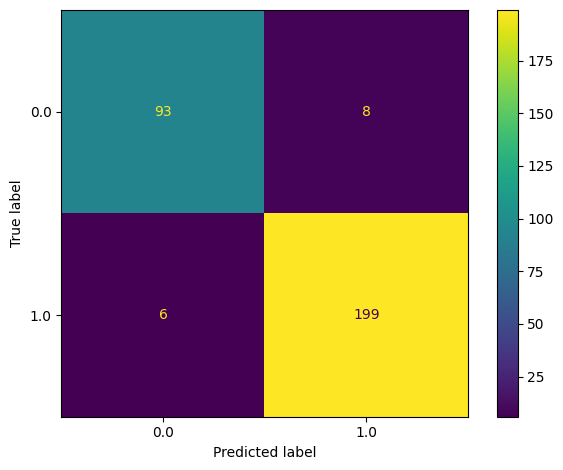

                       precision    recall  f1-score   support

   Under 800 calories       0.94      0.92      0.93       101
800 calories and over       0.96      0.97      0.97       205

             accuracy                           0.95       306
            macro avg       0.95      0.95      0.95       306
         weighted avg       0.95      0.95      0.95       306



In [34]:

lsvc = svm.LinearSVC(random_state=42)

param_grid = {'penalty':['l2'],
              'loss':['hinge','squared_hinge'],
              'C':[0.001,0.01,0.1,1.0,10.0]}

warnings.filterwarnings('ignore')
grid_search = GridSearchCV(lsvc,param_grid=param_grid)
grid_search.fit(X_train,y_train)

warnings.resetwarnings()
print(f'Best hyperparameters for LinearSVC: {grid_search.best_params_}')
print(f'Score: {grid_search.score(X_test,y_test)}')
labels = ['Under 800 calories', '800 calories and over']
lsvc_predictions = grid_search.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lsvc_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, lsvc_predictions, target_names=labels))

By fine tuning the hyperparameters, we can improve the performance of the LinearSVC model, beating out even the Linear Regression, in terms of accuracy.

Furthermore, we see that the false predictions have gone down to just 14 from the previous model's 19.

### SVC

As the LinearSVC performed slightly worse without hyperparametes, we will train the SVC directly with hyperparamaters tuning.

Best hyperparameters for SVC: {'C': 10, 'kernel': 'linear'}
Score: 0.9509803921568627


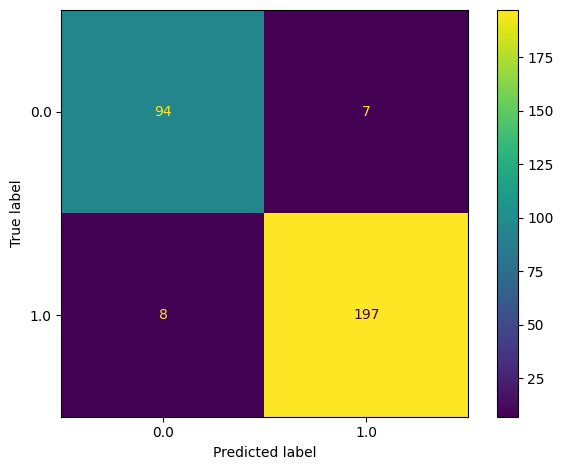

                       precision    recall  f1-score   support

   Under 800 calories       0.92      0.93      0.93       101
800 calories and over       0.97      0.96      0.96       205

             accuracy                           0.95       306
            macro avg       0.94      0.95      0.94       306
         weighted avg       0.95      0.95      0.95       306



In [35]:

svc = SVC(random_state=42)

param_grid = [
            {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
            {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

warnings.filterwarnings('ignore')
grid_search = GridSearchCV(svc,param_grid=param_grid)
grid_search.fit(X_train,y_train)

warnings.resetwarnings()
print(f'Best hyperparameters for SVC: {grid_search.best_params_}')
print(f'Score: {grid_search.score(X_test,y_test)}')
labels = ['Under 800 calories', '800 calories and over']
svc_predictions = grid_search.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, svc_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, svc_predictions, target_names=labels))

As we can see, the SVC performs slightly worse than the LinearSVC in terms of accuracy.
However, it labels the negative class slightly better in the expense of the positive class.

### Decision Tree 

Again jumping straight into hyperparameters tuning.

Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
Score: 0.8856209150326797


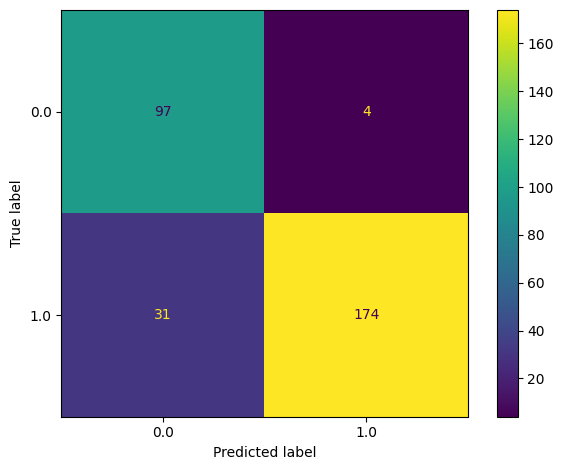

                       precision    recall  f1-score   support

   Under 800 calories       0.76      0.96      0.85       101
800 calories and over       0.98      0.85      0.91       205

             accuracy                           0.89       306
            macro avg       0.87      0.90      0.88       306
         weighted avg       0.91      0.89      0.89       306



In [36]:
dec_tree = DecisionTreeClassifier(random_state=42)

param_grid = {
                'criterion': ['gini','entropy'],
                'splitter': ['best','random'],
                'max_depth': [1,2,5,10,20]}

warnings.filterwarnings('ignore')
grid_search = GridSearchCV(dec_tree,param_grid=param_grid)
grid_search.fit(X_train,y_train)
warnings.resetwarnings()

print(f'Best hyperparameters for Decision Tree: {grid_search.best_params_}')
print(f'Score: {grid_search.score(X_test,y_test)}')
labels = ['Under 800 calories', '800 calories and over']
tree_predictions = grid_search.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, tree_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, tree_predictions, target_names=labels))

The Decision Tree model performs the second worst out of all trained so far (only after KNN).

Not only is its accuracy the lowest (high 80's compared to low-to-mid 90's), the labeling for the positive class has the highest error by far. Interestingly enough it has the lowest error for the negative class out of every model. This however could be explained by it having a high bias for the positive class in general.

### Random Forest

Our final model will be the Random Forest. As with the previous two we jump in straight into the hyperparameters tuning.

Best hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': 20, 'max_features': 0.6, 'n_estimators': 100}
Score: 0.9281045751633987


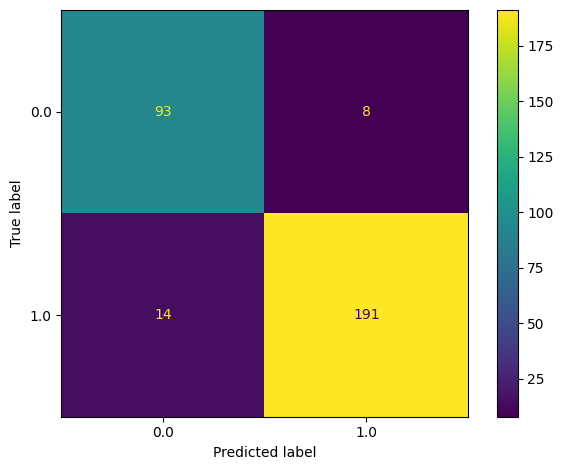

                       precision    recall  f1-score   support

   Under 800 calories       0.87      0.92      0.89       101
800 calories and over       0.96      0.93      0.95       205

             accuracy                           0.93       306
            macro avg       0.91      0.93      0.92       306
         weighted avg       0.93      0.93      0.93       306



In [38]:
forest = RandomForestClassifier(random_state=42)

param_grid = {
                'criterion': ['gini','entropy'],
                #'n_estimators': [10,100,200,500,1000] - Originally supposed to be this, but it takes upwards of 8 minutes 💀
                'n_estimators': [10,100,200],           # And 100 is always the best estimator anyways.
                'max_depth': [1,2,5,10,20],
                'max_features': [0.1,0.4,0.6,0.8,1.0]}

warnings.filterwarnings('ignore')
grid_search = GridSearchCV(forest,param_grid=param_grid)
grid_search.fit(X_train,y_train)
warnings.resetwarnings()

print(f'Best hyperparameters for Decision Tree: {grid_search.best_params_}')
print(f'Score: {grid_search.score(X_test,y_test)}')
labels = ['Under 800 calories', '800 calories and over']
forest_predictions = grid_search.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, forest_predictions)
plt.tight_layout()
plt.show()
print(classification_report(y_test, forest_predictions, target_names=labels))

Despite taking more than 10 times longer to compile (really) than all previous models' times combined, the Random Forest is the third worst model, only outperforming Decision Tree and KNN. Its lack of accuracy does not even get compensated for by its positive labeling accuracy like the Decision Tree. 

## Conclusion

### Features
- The most important features for this model appear to be Session Duration, Height and Gender (wether the person is Male or not).
- The least important features that can outright be removed from the dataframe are Weight, Max BPM, Resting BPM, BMI and Fat Percentage.

### Models

Despite being among the less complex models, the LinearSVC models outperforms the rest both in accuracy and precision in labeling.

Accuracy comparison (Best to Worse): 
1) **LinearSVC - 0.954 (Best hyperparameters: C=10, loss=squared_hinge, penalty = l2)**
2) SVC - 0.950 (Best hyperparametes: C=10, kernel = linear)
3) Logistic Regression - 0.934 
4) Random Forest - 0.928 (Best hyperparameters: criterion = gini, max_depth = 20, max_features = 0.6, n_estimators = 100)
5) Decision Tree - 0.885 (Best hyperparametes:  crietrion = entropy, max_depth = 5, splitter = random)
6) KNN - 0.768 (with 5 neighbours)

As for the precision (True Positives vs True Negatives / Ordered by accuracy again)

- LinearSVC - 0.96 v **0.94**
- SVC - 0.97 vs 0.92
- Logistic Regression - **0.99** vs 0.85
- Random Forest - 0.96 vs 0.87
- Decision Tree - 0.98 vs 0.76
- KNN - 0.81 vs 0.67

As we can see the Logistic Regression has the highest precision when it comes to labeling the True Positives.

The LinearSVC not only has the highest precision when it comes to labeling False Positives but has the best ratio between the two precisions ( unsurprisingly as it has the highest accuracy).